In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from isaacgym import gymtorch
from isaacgym import gymapi

from bc_algos.envs.isaacgym_simple import IsaacGymEnvSimple
# from bc_algos.dataset.robomimic import RobomimicDataset
from bc_algos.dataset.isaac_gym import IsaacGymDataset
# from bc_algos.envs.robosuite import RobosuiteEnv
from bc_algos.utils.constants import Modality
import bc_algos.utils.constants as Constants
import matplotlib.pyplot as plt
import json
import numpy as np

# change this to test different simulator environments
type = Constants.EnvType.ISAAC_GYM

Importing module 'gym_37' (/home/markvdm/Documents/IsaacGym/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_37.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/markvdm/Documents/IsaacGym/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 1.8.1
Device count 1
/home/markvdm/Documents/IsaacGym/isaacgym/python/isaacgym/_bindings/src/gymtorch
Using /home/markvdm/.cache/torch_extensions as PyTorch extensions root...
Emitting ninja build file /home/markvdm/.cache/torch_extensions/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module gymtorch...


2024-04-23 13:36:51,263 - INFO - logger - logger initialized
<unknown>:6: DeprecationWarning: invalid escape sequence \*
/home/markvdm/Documents/IsaacGym/isaacgym/python/isaacgym/torch_utils.py:135: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def get_axis_params(value, axis_idx, x_value=0., dtype=np.float, n_dims=3):


Error: FBX library failed to load - importing FBX data will not succeed. Message: No module named 'fbx'
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/networkx/classes/graph.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, Set, Iterable
/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

[2024-04-23 13:36:52,091] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  NVIDIA Inference is only supported on Ampere and newer architectures


/home/markvdm/miniconda3/envs/isaacgym/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/torchvision/transforms/functional_pil.py:207: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize(img, size, interpolation=Image.BILINEAR):
/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/torchvision/transforms/functional_pil.py:280: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def perspective(img, perspective_coeffs, interpolation=Image.BICUBIC, fill=None):
/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/matplotlib/__in

### Dataset Init

In [3]:
obs_key_to_modality = {
    "robot0_eef_pos": Modality.LOW_DIM,
    "robot0_eef_quat": Modality.LOW_DIM,
    "agentview_image": Modality.RGB
}
obs_group_to_key = {
    "obs": ["robot0_eef_pos", "robot0_eef_quat", "agentview_image"],
    "goal": ["agentview_image"]
}

if type == Constants.EnvType.ROBOSUITE:
    path = "../datasets/test/square_ph.hdf5"
    action_key = "actions"
    demo = "demo_0"

elif type == Constants.DatasetType.ISAAC_GYM:
    path = "/home/markvdm/Documents/IsaacGym/mental_models_envs/out/mm_simple/dataset_v13_diff"
    action_key = "actions"
    demo = 3

In [4]:
if type == Constants.EnvType.ROBOSUITE:
    dataset = RobomimicDataset(
        path=path,
        obs_key_to_modality=obs_key_to_modality,
        obs_group_to_key=obs_group_to_key,
        dataset_keys=[action_key],
        frame_stack=0,
        seq_length=1,
        pad_frame_stack=False,
        pad_seq_length=False,
        get_pad_mask=False,
        demos=[demo],
        normalize=False,
    )

if type == Constants.EnvType.ISAAC_GYM:
    dataset = IsaacGymDataset(
        path=path,
        obs_key_to_modality=obs_key_to_modality,
        obs_group_to_key=obs_group_to_key,
        dataset_keys=[action_key],
        frame_stack=0,
        seq_length=1,
        pad_frame_stack=False,
        pad_seq_length=False,
        get_pad_mask=False,
        demos=[demo],
        normalize=False,
    )

caching index: 100%|██████████| 28/28 [00:00<00:00, 94102.97demo/s]


### Environment Init

In [5]:
if type == Constants.EnvType.ROBOSUITE:
    env_meta = json.loads(dataset.hdf5_file["data"].attrs["env_args"])
    env = RobosuiteEnv(
        env_name=env_meta["env_name"],
        obs_key_to_modality=obs_key_to_modality,
        render=False,
        use_image_obs=True,
        use_depth_obs=False,
        **env_meta["env_kwargs"],
    )
elif type == Constants.EnvType.ISAAC_GYM:
    env_cfg_file = "../config/isaac_gym_env.json"
    cfg = json.load(open(env_cfg_file, "r"))
    env = IsaacGymEnvSimple(
        env_name="isaac_gyn_env_simple",
        obs_key_to_modality=obs_key_to_modality,
        render=False,
        use_image_obs=True,
        use_depth_obs=False,
        cfg=cfg,
    )

/home/markvdm/miniconda3/envs/isaacgym/lib/python3.7/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
num franka bodies:  16
num franka dofs:  9
[Warning] [carb.gym.plugin] Acquiring DOF force tensor, but no actors have DOF force sensors enabled.
[Warning] [carb.gym.plugin] -> Enabled DOF force sensors for all eligible actors.


### Test Environment

des q: [ 0.01911699  0.11994138 -0.02251467 -2.6209788   0.02397788  2.8068216
  0.04615622  0.03999984  0.03999987]
q: tensor([[ 0.0183,  0.1121, -0.0221, -2.6242,  0.0231,  2.8022,  0.0465,  0.0400,
          0.0400]], device='cuda:0')


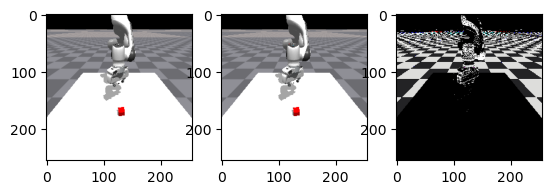

In [6]:
if type == Constants.EnvType.ROBOSUITE:
    xml = dataset.hdf5_file[f"data/{demo}"].attrs["model_file"]
    env.load_env(xml=xml)
    init_state = dataset.hdf5_file[f"data/{demo}/states"][0]
    env.reset_to(state=init_state)
elif type == Constants.EnvType.ISAAC_GYM:
    demo_metadata = dataset.dataset[demo]["metadata"]
    env.reset_to(state=demo_metadata)

ref_image = dataset[0]["obs"]["agentview_image"][0]
curr_image = env.render()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(ref_image)
axs[1].imshow(curr_image)
axs[2].imshow((curr_image - ref_image)[:, :, :3])
plt.show()


In [7]:
from matplotlib.animation import FuncAnimation, PillowWriter

# 
# 


# def animate_rollout(i):
for i in range(len(dataset)):
    frame = dataset[i]
    action = frame[action_key][0]

    final_img = env.render()
    ref_image = frame["obs"]["agentview_image"][0]

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(ref_image)
    axs[0].set_title("Reference")
    axs[1].imshow(final_img)
    axs[1].set_title("Execution")
    plt.savefig(f"../out/test_rollout/{i}.png")
    plt.draw()
    # axs[2].imshow((curr_image - ref_image)[:, :, :3])
    plt.close()

    env.step(action=action)

    # plt.show()


# ani = FuncAnimation(fig, animate_rollout, frames=len(dataset), interval=1.0 / 8.0)
# ani.save("../out/test_rollout/rollout.gif", dpi=300, writer=PillowWriter(fps=8))